In [7]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from analysis_utils import load_metrics_from_subdir, wrap_metrics_hooks_to_df

# set mpl font sizing
SMALL_SIZE = 20
MEDIUM_SIZE = 28
BIGGER_SIZE = 30

plt.rc("font", size=BIGGER_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
font_family = "serif"

# set seaborn styling
sns.set_style("whitegrid")
n_colors = 9
cms_color = {
    color: sns.color_palette(color, n_colors)
    for color in ["Blues", "Greens", "Reds", "Oranges", "Purples", "Greys"]
}

### Define loading of the data

In [8]:
def load_merged_df(mc_dir: str, hook_file_template: str = "hooks_config.p"):
    # set output figure directory
    fig_dir_out = os.path.join("figures", mc_dir)
    if os.path.exists(fig_dir_out):
        shutil.rmtree(fig_dir_out)
    os.makedirs(fig_dir_out)

    # load in the metrics and hook configs
    metrics_dir = os.path.join("metrics", "mc_tuning", mc_dir)
    metrics_trials, hooks_trials = load_metrics_from_subdir(
        metrics_dir, hook_file_template
    )
    metrics_df, hooks_df = wrap_metrics_hooks_to_df(metrics_trials, hooks_trials)

    # merge the two dictionaries
    merged_df = pd.merge(
        metrics_df, hooks_df, left_on="hook", right_index=True, how="left"
    )
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    merged_df.dropna(how="all", inplace=True)
    print(merged_df.shape)
    merged_df.columns

    return merged_df, fig_dir_out

### Define plots of the performance

In [9]:
def make_plot_percentiles(
    df: pd.DataFrame,
    ax,
    cmap: list,
    param_index: str,
    outcome_index: str,
    label: str,
    show_percentiles: bool = True,
    use_twin_ax: bool = False,
):
    """Make marginal plot with percentiles"""
    if use_twin_ax:
        ax = ax.twinx()

    # add the percentiles
    if show_percentiles:
        for ix, ci in enumerate(range(10, 100, 10)):
            # add hues
            sns.lineplot(
                data=df,
                x=param_index,
                y=outcome_index,
                errorbar=("ci", ci),
                ax=ax,
                linestyle="" if ci != 50 else "-",
                hue=ci,
                palette={ci: cmap[ix]},
                legend=False,
                linewidth=1,
                label="" if ci != 50 else label,
            )

    # always add the median line
    sns.lineplot(
        data=df,
        x=param_index,
        y=outcome_index,
        errorbar=("ci", 50),
        ax=ax,
        linestyle="--",
        hue=50,
        palette=["black"] if show_percentiles else [cmap[4]],
        legend=False,
        linewidth=2,
        alpha=0.5,
        label="" if show_percentiles else label,
    )


def marginal_plot_over_grouped_df(
    ax,
    df_grouped: pd.DataFrame,
    loop_tuples: list,
    param_index: str,
    param_name: str,
    show_legend: bool,
    savefig_ext: str,
    fig_save_dir: str,
):
    # plot confidence intervals for lines
    for outcome_index, label, cmap_name in loop_tuples:
        # make the percentile plots
        make_plot_percentiles(
            df=df_grouped,
            ax=ax,
            cmap=cms_color[cmap_name],
            param_index=param_index,
            outcome_index=outcome_index,
            label=label,
            show_percentiles=True,
            use_twin_ax=False,
        )

    ax.set_title('MC Tuning "{}"'.format(param_name), family=font_family)
    ax.set_xlabel("Parameter Value", family=font_family)
    ax.set_ylabel("Performance Metric", family=font_family)
    ax.set_ylim([0.5, 1.0])
    if show_legend:
        leg = ax.legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.19),
            ncol=2,
            fancybox=True,
            shadow=True,
            prop={"family": font_family},
        )

        # set the linewidth of each legend object
        for legobj in leg.legend_handles:
            legobj.set_linewidth(4.0)
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            fig_save_dir, "trust_tune_{}_{}.pdf".format(param_index, savefig_ext)
        )
    )
    plt.savefig(
        os.path.join(
            fig_save_dir, "trust_tune_{}_{}.png".format(param_index, savefig_ext)
        )
    )
    plt.show()

In [4]:
def make_marginal_parameter_tuning_plots(
    merged_df: pd.DataFrame, fig_dir_out: str, param_index: str
):
    # define all the things to plot
    param_name = (" ".join(param_index.split("_"))).title()
    loop_tuples = [
        ("trusted_f1", "F1 Score on Trusted Tracks", "Reds"),
        ("trusted_precision", "Precision on Trusted Tracks", "Purples"),
        ("trusted_recall", "Recall on Trusted Tracks", "Greys"),
        ("metric_agent", "Mean Agent Trust Metric", "Blues"),
        ("metric_track", "Mean Track Trust Metric", "Greens"),
    ]

    # take the median across frames at a given hook and trial
    merged_df_grouped_median = merged_df.groupby(
        by=["hook", "trial", param_index]
    ).median()
    merged_df_grouped_twosigma_below = merged_df.groupby(
        by=["hook", "trial", param_index]
    ).quantile(0.023)

    # plot the median version
    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    marginal_plot_over_grouped_df(
        ax=ax,
        df_grouped=merged_df_grouped_median,
        loop_tuples=loop_tuples,
        param_index=param_index,
        param_name=param_name,
        show_legend=True,
        savefig_ext="median",
        fig_save_dir=fig_dir_out,
    )

    # plot the (-2*sigma) version
    fig, ax = plt.subplots(1, 1, figsize=(10, 9))
    marginal_plot_over_grouped_df(
        ax=ax,
        df_grouped=merged_df_grouped_twosigma_below,
        loop_tuples=loop_tuples,
        param_index=param_index,
        param_name=param_name,
        show_legend=True,
        savefig_ext="twosigmabelow",
        fig_save_dir=fig_dir_out,
    )

### Plot negativity bias marginals

In [5]:
merged_df_neg_bias, fig_neg_bias_out = load_merged_df("mc_trust_tune_neg_bias")

(205500, 27)


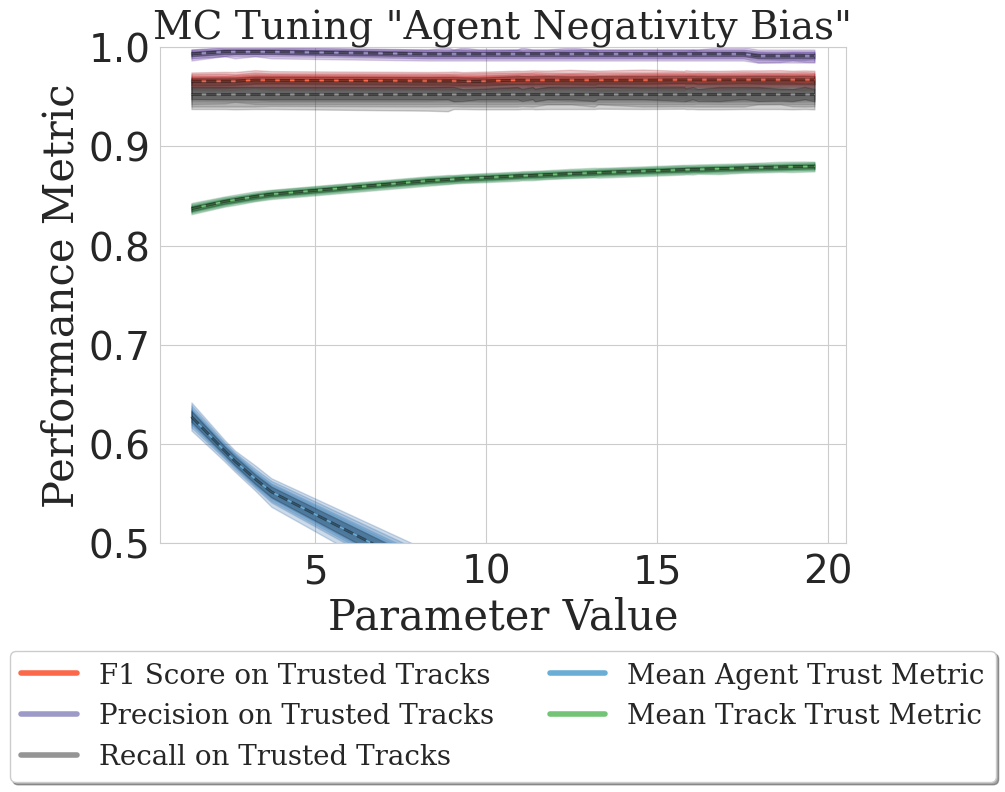

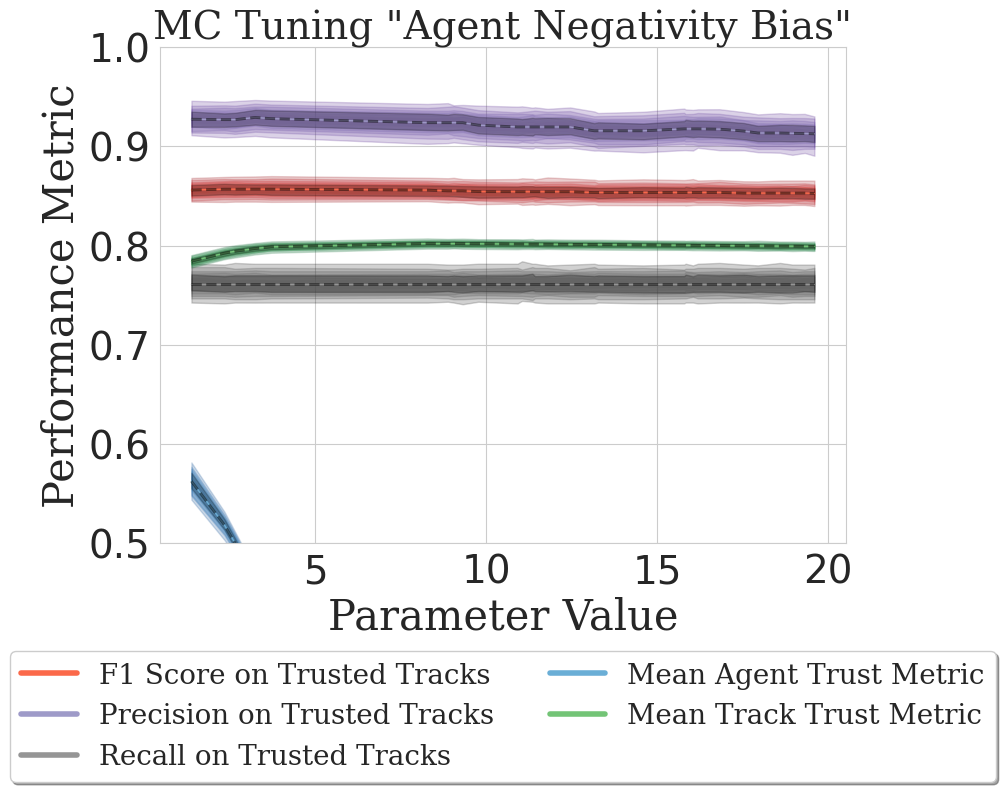

In [6]:
param_index_neg_bias = "agent_negativity_bias"
make_marginal_parameter_tuning_plots(
    merged_df=merged_df_neg_bias,
    fig_dir_out=fig_neg_bias_out,
    param_index=param_index_neg_bias,
)

### Plot Negativity Threshold Marginal

In [7]:
merged_df_neg_bias_thresh, fig_neg_bias_thresh_out = load_merged_df(
    "mc_trust_tune_neg_bias_threshold"
)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x741ca47ef1c0>>
Traceback (most recent call last):
  File "/home/spencer/.cache/pypoetry/virtualenvs/multi-agent-ros-haJq234Z-py3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x741ca47ef1c0>>
Traceback (most recent call last):
  File "/home/spencer/.cache/pypoetry/virtualenvs/multi-agent-ros-haJq234Z-py3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
param_index_neg_bias = "agent_negativity_bias"
param_index_neg_thresh = "agent_negativity_threshold"

make_marginal_parameter_tuning_plots(
    merged_df=merged_df_neg_bias_thresh,
    fig_dir_out=fig_neg_bias_thresh_out,
    param_index=param_index_neg_bias,
)

make_marginal_parameter_tuning_plots(
    merged_df=merged_df_neg_bias_thresh,
    fig_dir_out=fig_neg_bias_thresh_out,
    param_index=param_index_neg_thresh,
)

In [ ]:
####################################################
# Do a pair grid between the outcome metrics
####################################################

metrics_columns = [
    "trusted_f1",
    "trusted_precision",
    "trusted_recall",
    "metric_agent",
    "metric_track",
]
g = sns.PairGrid(merged_df_grouped_median[metrics_columns], diag_sharey=False)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=False)
g.map_diag(sns.histplot, kde=True)
plt.show()

In [ ]:
####################################################
# Show the two-dimensional surface dependency
# between negativity bias and threshold
####################################################

param_indices_2 = ["agent_negativity_bias", "agent_negativity_threshold"]
param_name_2 = ["Agent Negativity Bias", "Agent Negativity Threshold"]
loop_tuples_outcomes = [
    ("trusted_f1", "F1 Score on Trusted Tracks", "Reds"),
    ("trusted_precision", "Precision on Trusted Tracks", "Purples"),
    ("trusted_recall", "Recall on Trusted Tracks", "Greys"),
    ("metric_agent", "Mean Agent Trust Metric", "Blues"),
    ("metric_track", "Mean Track Trust Metric", "Greens"),
]
idx_outcome = 0

# bin the two parameters for robustness


# take a median of the binned results


# show the surface plot


# set plot labels and things
ax.set_title(
    'Monte Carlo Tuning "{}" and "{}"'.format(*param_name_2), family=font_family
)
ax.set_xlabel("{} Parameter".format(param_name_2[0]), family=font_family)
ax.set_ylabel("{} Parameter".format(param_name_2[1]), family=font_family)
plt.tight_layout()
plt.savefig(
    os.path.join(fig_out, "trust_tune_{}_and_{}_surface.pdf".format(*param_indices_2))
)
plt.savefig(
    os.path.join(fig_out, "trust_tune_{}_and_{}_surface.png".format(*param_indices_2))
)
plt.show()